<a href="https://colab.research.google.com/github/PiotMik/OIS_curve_modeling/blob/main/OIS_Curve_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
import os
sns.set()
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10, 8)

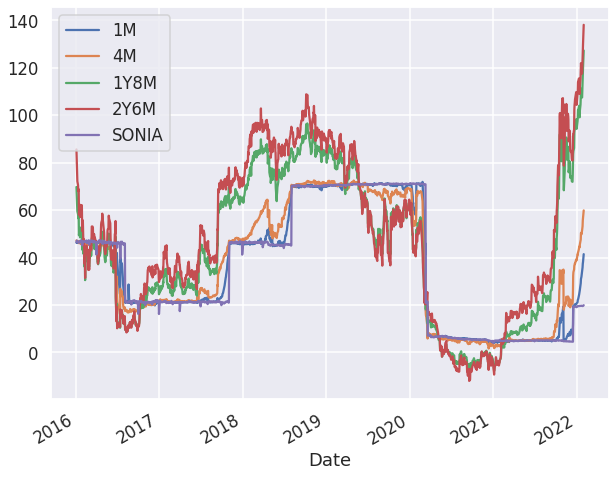

In [130]:
ois_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/OIS%20spot.csv'
sonia_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/SONIA.csv'

def tenor_parser(month_number: int):
  """
  Refactor integer month number into string like: 23 -> '1Y3Q2M' 

  Parameters
  ----------
  month_number: int
    Integer representing the number of months
  
  Returns
  -------
  str
    Formatted string
  """
  years = np.floor(month_number/12)
  months = (month_number - 12*years)

  y_str = f"{int(years)}Y" * int(years > 0)
  m_str = f"{int(months)}M" * int(months > 0)
  
  return y_str + m_str


ois = pd.read_csv(ois_url,
                  index_col= ['Maturity'], parse_dates=True, dayfirst=True)
ois = ois.sort_index()*100.0
ois.columns = [tenor_parser(int(month)) for month in ois.columns]
ois.index.name = 'Date'

sonia = pd.read_csv(sonia_url,
                    index_col=['Date'], parse_dates=True, dayfirst=True)
sonia = sonia.sort_index()* 100.0

rates = pd.concat([sonia, ois], axis = 1).dropna()
rates.iloc[:, [1, 4, 20, 30, 0]].plot()

In [132]:
tenor_subset = ['1M', '2M', '3M', '6M', '9M', '1Y']
df = rates[tenor_subset]

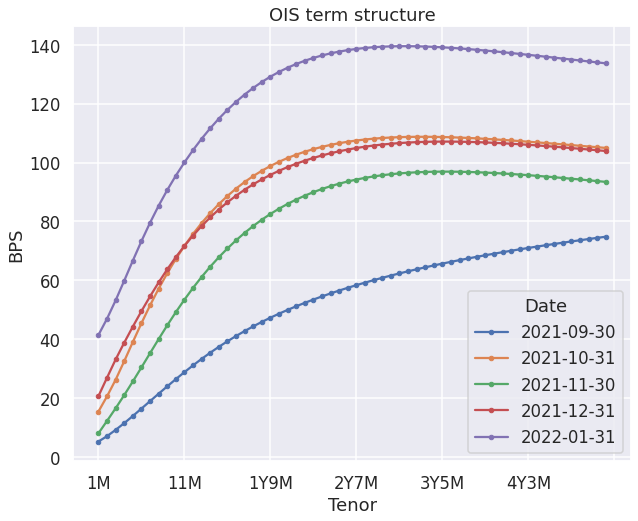

In [135]:
term_structure_df = rates.drop(['SONIA'], axis=1).tail(100).resample('M').last().T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')

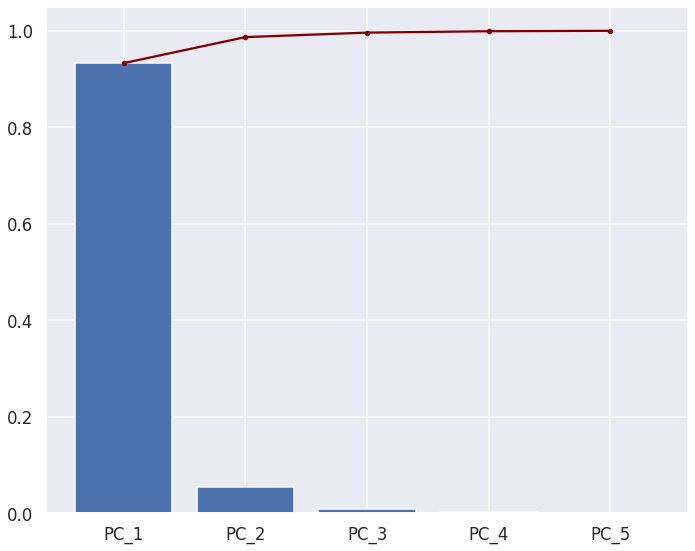

In [182]:
diffs = rates[ois.columns].diff().dropna()
pca = PCA()
pca.fit(diffs)

exp_var = pd.DataFrame(pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
exp_var['Cumulative explained variance'] = pca.explained_variance_ratio_.cumsum()

max_n = 5
plt.bar(x = exp_var.index[:max_n], height = exp_var['Explained variance'][:max_n])
plt.plot(exp_var['Cumulative explained variance'][:max_n], marker='.', color='maroon')
plt.tight_layout()

In [140]:
exp_var.head(10)

,Explained variance,Cumulative explained variance
PC_1,0.931762,0.931762
PC_2,0.054565,0.986327
PC_3,0.009380,0.995707
PC_4,0.002851,0.998558
PC_5,0.000871,0.999429
PC_6,0.000382,0.999811
PC_7,0.000128,0.999939
PC_8,0.000042,0.999982
PC_9,0.000014,0.999996
PC_10,0.000003,0.999999


,Cumulative explained variance
PC_1,0.932507
PC_2,0.986371
PC_3,0.995707


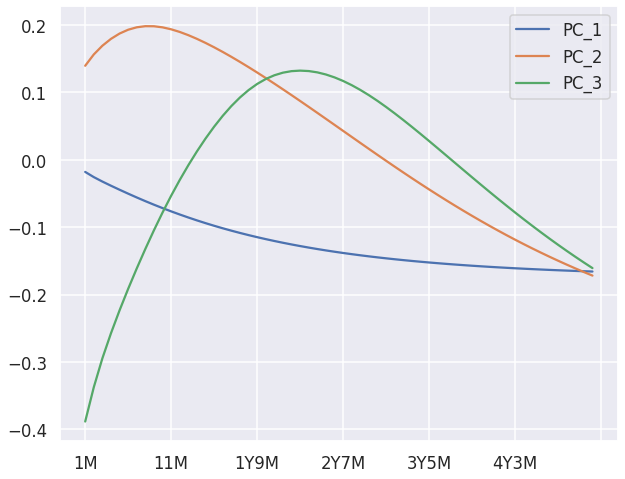

In [183]:
pca = PCA(3)
pca.fit(diffs)

components = pd.DataFrame(pca.components_, 
                          columns = diffs.columns, index=[f'PC_{i + 1}' for i in range(pca.n_components)]).T
components.plot()
pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
             columns = ['Cumulative explained variance'],
             index = [f'PC_{i+1}' for i in range(pca.n_components)])